In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

import seaborn as sns
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from fbprophet import Prophet

In [4]:
raw_df = pd.read_csv('hotel_bookings.csv',parse_dates=True)
df = raw_df

In [5]:
# Get arrival date month

month_dict = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,
    'November':11,'December':12}

df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: month_dict[x])

In [6]:
def Convert_dt(x,df):
    temp_df =  df[x:x+1]
    y = temp_df['arrival_date_year'].values[0]
    m = temp_df['arrival_date_month'].values[0]
    d = temp_df['arrival_date_day_of_month'].values[0]
#     date = {'year': y, 'month': m,'day': d}
    if m < 10:
        m = '0'+str(m)
    else:
        pass
    if d < 10:
        d = '0'+str(d)
    return str(y)+'-'+str(m)+'-'+str(d)

In [7]:
def true_false(x):
    if x == True:
        return 1
    else:
        return 0

In [8]:
df = df.reset_index()
df['arrival_date'] = df['index'].apply(lambda x: Convert_dt(x,df))

In [9]:
df['arrival_date'] = pd.DatetimeIndex(df['arrival_date'])
df['reservation_status_date'] = pd.DatetimeIndex(df['reservation_status_date'])

In [10]:
df = df[['index','arrival_date','reservation_status', 'reservation_status_date',
       'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'customer_type', 'adr',
       'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests']]

In [11]:
df['LOS'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

In [12]:
# City/Resort Hotels with 0 LOS
print('City Hotels with 0 LOS')
print(len(df[(df['LOS']==0) & (df['hotel'] == 'City Hotel')]
          [['stays_in_weekend_nights','stays_in_week_nights']]))


print('Resort Hotels with 0 LOS')
print(len(df[(df['LOS']==0) & (df['hotel'] == 'Resort Hotel')]
          [['stays_in_weekend_nights','stays_in_week_nights']]))

City Hotels with 0 LOS
331
Resort Hotels with 0 LOS
384


In [13]:
# Seperate entries with zero roomnights
df_no_los = df[df['LOS']==0]
df = df[df['LOS']!=0]

In [14]:
# Add Last Stay Date Column
df['last_stay_date'] = df['arrival_date'] + df['LOS'].apply(lambda x: pd.DateOffset(x-1))

In [15]:
# Got Room Request column
df['room_request_equals_assigned'] = df['reserved_room_type'] == df['assigned_room_type']
df['room_request_equals_assigned'] = df['room_request_equals_assigned'].apply(lambda x: true_false(x))

In [16]:
# Zero Dollar ADR column
df['comp_adr'] = df['adr'].apply(lambda x: x==0)
df['comp_adr'] = df['comp_adr'].apply(lambda x: true_false(x))

In [17]:
# Outlier ADR
df.sort_values('adr',ascending=False)['adr'].head()

48515     5400.0
111403     510.0
15083      508.0
103912     451.5
13142      450.0
Name: adr, dtype: float64

In [18]:
# Non-canceled occupant counts
df[df['reservation_status']!='Canceled']['adults'].value_counts()

2    54709
1    16603
3     4082
0      240
4       46
Name: adults, dtype: int64

In [19]:
df_no_occupants = df[df['adults']==0]
df = df[df['adults']>0]

In [20]:
# Children value counts
df['children'].value_counts()

0.0     110005
1.0       4838
2.0       3429
3.0         65
10.0         1
Name: children, dtype: int64

In [21]:
# Babies value counts
df['babies'].value_counts()

0     117433
1        892
2         15
10         1
9          1
Name: babies, dtype: int64

In [22]:
# Parking Spaces value counts
df['required_car_parking_spaces'].value_counts()

0    110951
1      7358
2        28
3         3
8         2
Name: required_car_parking_spaces, dtype: int64

In [23]:
# Special Requests value counts
df['total_of_special_requests'].value_counts()

0    69732
1    32907
2    12853
3     2472
4      338
5       40
Name: total_of_special_requests, dtype: int64

In [24]:
# CXL > 9
df[df['previous_cancellations']>9]['reservation_status'].value_counts()

Canceled     154
Check-Out     26
Name: reservation_status, dtype: int64

In [25]:
# Distobution value Counts
df['distribution_channel'].value_counts()

TA/TO        97145
Direct       14418
Corporate     6584
GDS            190
Undefined        5
Name: distribution_channel, dtype: int64

In [26]:
# Remove Outliers
df = df[df['children'] < 10]
df = df[df['babies'] < 10]
df = df[df['required_car_parking_spaces'] < 8]
df = df[df['previous_cancellations'] < 10]
df = df[df['distribution_channel'] != 'Undefined']
df = df[df['adr']<1000]

In [27]:
# Get top 50 Agent List
agent_bookings_df = df.groupby('agent').count().sort_values('index',ascending=False)[['hotel']]
agent_bookings_df = agent_bookings_df.reset_index()
agent_bookings_df.columns = ['agent','bookings']
top_50_agent_list = agent_bookings_df[:50]['agent'].values

In [28]:
# Customer Type and reservation status
df.groupby(['customer_type','reservation_status']).count()['index']

customer_type    reservation_status
Contract         Canceled               1236
                 Check-Out              2793
                 No-Show                  25
Group            Canceled                 54
                 Check-Out               510
                 No-Show                   4
Transient        Canceled              35361
                 Check-Out             52357
                 No-Show                 941
Transient-Party  Canceled               6092
                 Check-Out             18560
                 No-Show                 219
Name: index, dtype: int64

In [29]:
# dropping company column
df = df.drop(columns='company')

In [30]:
# Split to two hotel df
city_df = df[df['hotel']=='City Hotel']
resort_df = df[df['hotel']=='Resort Hotel']

In [31]:
# plotting city arrivals (checked out)
city_arrivals = city_df[city_df['reservation_status']=='Check-Out'].groupby('arrival_date').count()['hotel']
city_arrivals = city_arrivals.reset_index()
city_arrivals.columns = ['ds','y']

m = Prophet()
m.fit(city_arrivals)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


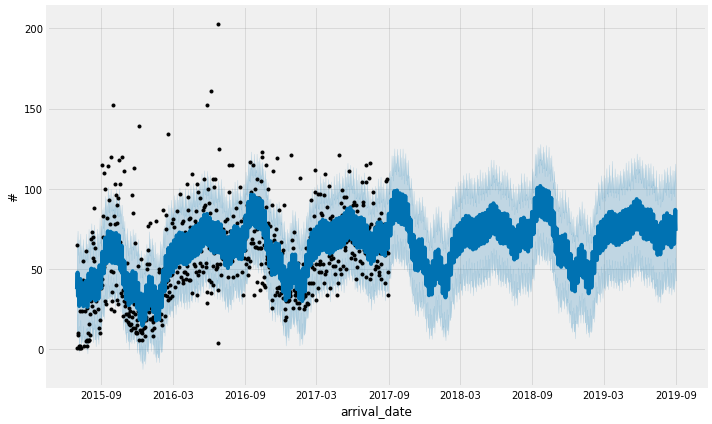

In [32]:
pd.plotting.register_matplotlib_converters()
m.plot(forecast,xlabel='arrival_date',ylabel='#');

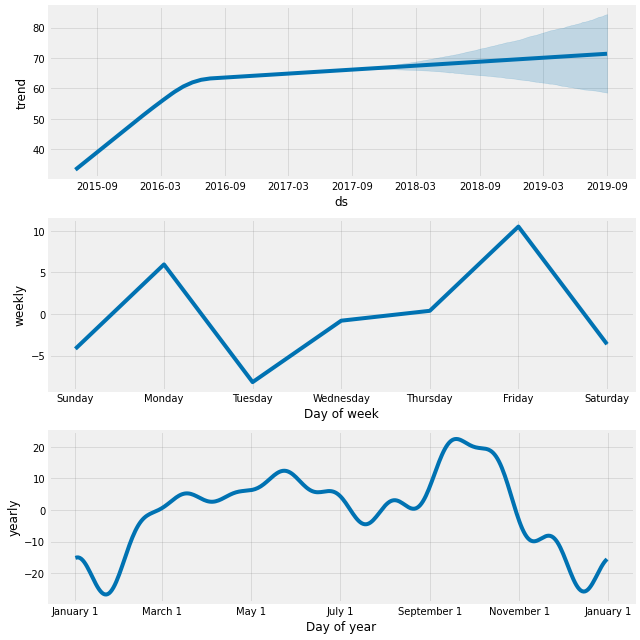

In [33]:
m.plot_components(forecast);

In [34]:
# plotting resort arrivals
resort_arrivals = resort_df[resort_df['reservation_status']=='Check-Out'].groupby('arrival_date').count()['hotel']
resort_arrivals = resort_arrivals.reset_index()
resort_arrivals.columns = ['ds','y']

m = Prophet()
m.fit(resort_arrivals)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


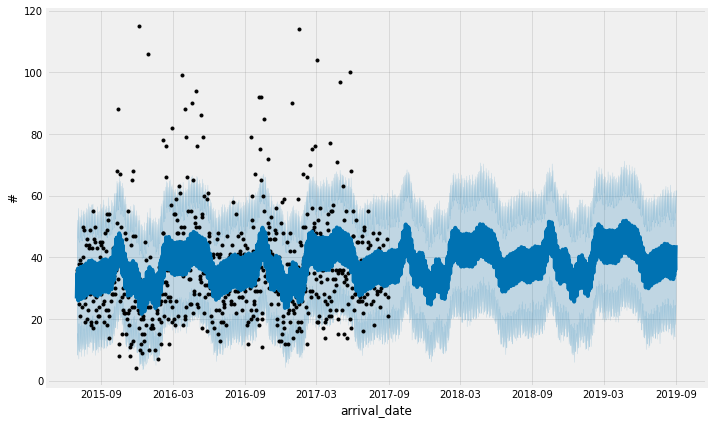

In [35]:
pd.plotting.register_matplotlib_converters()
m.plot(forecast,xlabel='arrival_date',ylabel='#');

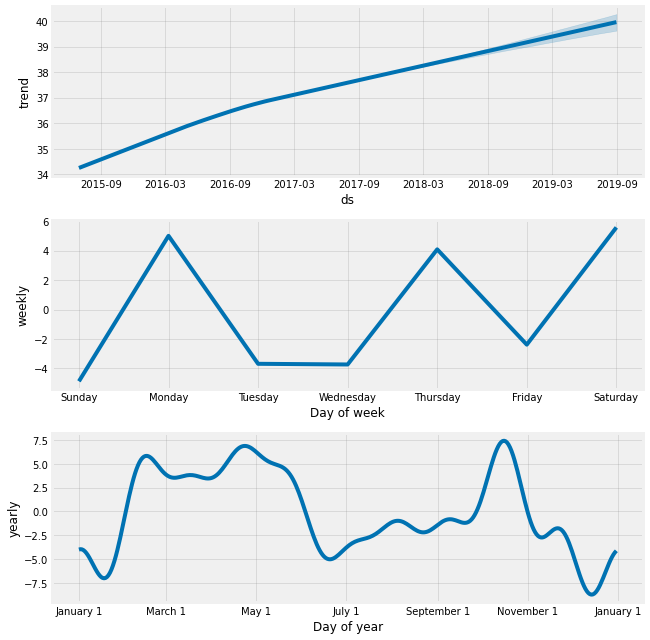

In [36]:
m.plot_components(forecast);

In [37]:
df_cat = df

In [38]:
df_cat = pd.get_dummies(df_cat,columns=['hotel','reservation_status','customer_type','market_segment','deposit_type','reserved_room_type','distribution_channel'],drop_first=True)

In [39]:
df_cat = df_cat[[
       'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adr', 'adults', 'children', 'babies',
        'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
        'booking_changes', 'agent',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'LOS',
       'room_request_equals_assigned', 'comp_adr', 'hotel_Resort Hotel',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L','distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO','reservation_status_Check-Out', 
                 'reservation_status_No-Show',]]

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X = df_cat[[
       'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adr', 'adults', 'children', 'babies',
        'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'LOS',
       'room_request_equals_assigned', 'comp_adr',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'reserved_room_type_B',
       'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E',
       'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H',
       'reserved_room_type_L','distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO','reservation_status_Check-Out', 
                 'reservation_status_No-Show',]]

y = df_cat['hotel_Resort Hotel']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
predictions = logmodel.predict(X_test)

In [46]:
from sklearn.metrics import classification_report

In [47]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86     25956
           1       0.78      0.55      0.64     13035

   micro avg       0.80      0.80      0.80     38991
   macro avg       0.79      0.74      0.75     38991
weighted avg       0.80      0.80      0.79     38991



In [48]:
df.head()

,index,arrival_date,reservation_status,reservation_status_date,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,...,booking_changes,deposit_type,agent,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,LOS,last_stay_date,room_request_equals_assigned,comp_adr
2,2,2015-07-01,Check-Out,2015-07-02,Resort Hotel,0,7,2015,7,27,...,0,No Deposit,NaN,0,0,0,1,2015-07-01,0,0
3,3,2015-07-01,Check-Out,2015-07-02,Resort Hotel,0,13,2015,7,27,...,0,No Deposit,304.0,0,0,0,1,2015-07-01,1,0
4,4,2015-07-01,Check-Out,2015-07-03,Resort Hotel,0,14,2015,7,27,...,0,No Deposit,240.0,0,0,1,2,2015-07-02,1,0
5,5,2015-07-01,Check-Out,2015-07-03,Resort Hotel,0,14,2015,7,27,...,0,No Deposit,240.0,0,0,1,2,2015-07-02,1,0
6,6,2015-07-01,Check-Out,2015-07-03,Resort Hotel,0,0,2015,7,27,...,0,No Deposit,NaN,0,0,0,2,2015-07-02,1,0


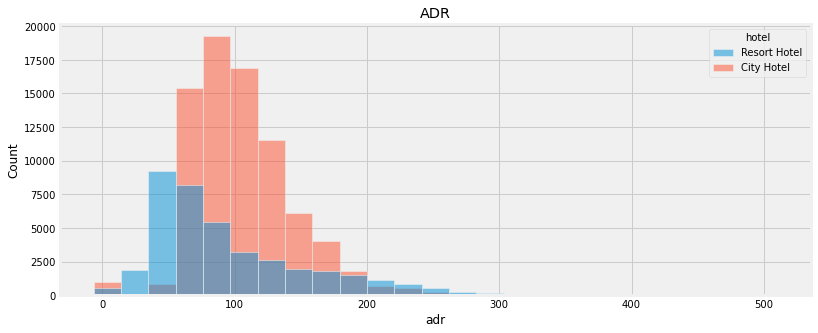

In [49]:
plt.figure(figsize = (12,5))
plt.title('ADR')
sns.histplot(data=df, x='adr', hue='hotel',bins=25);

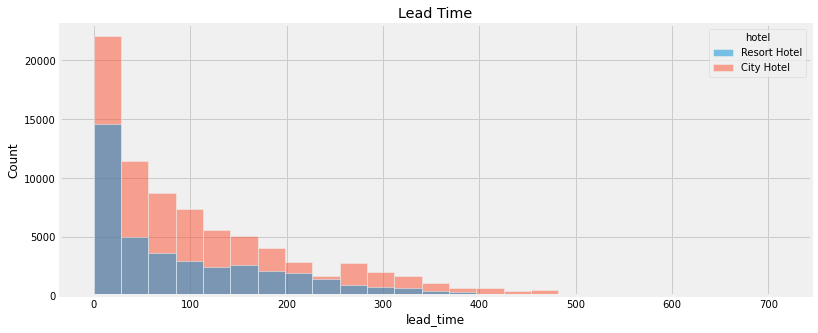

In [50]:
plt.figure(figsize = (12,5))
plt.title('Lead Time')
sns.histplot(data= df, x='lead_time', hue='hotel',bins=25);

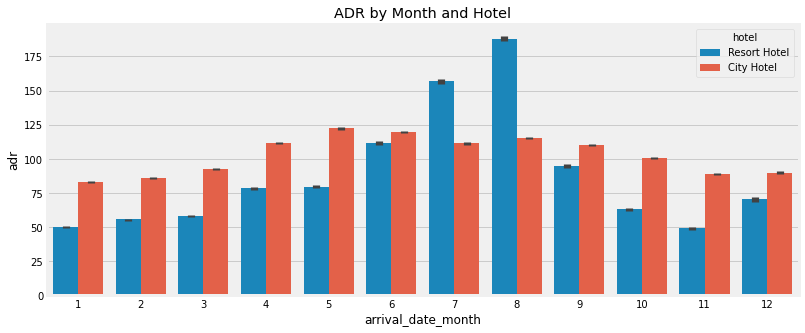

In [51]:
plt.figure(figsize = (12,5))
plt.title('ADR by Month and Hotel')
sns.barplot(x='arrival_date_month',y='adr',data=df,hue='hotel');

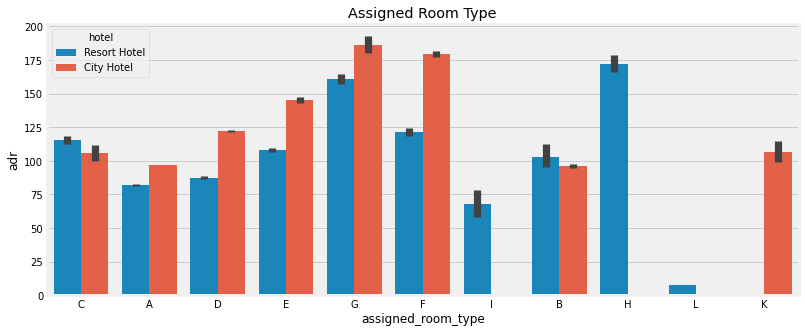

In [52]:
plt.figure(figsize = (12,5))
plt.title('Assigned Room Type')
sns.barplot(x='assigned_room_type',y='adr',data=df,hue='hotel');

In [53]:
df.groupby('deposit_type').mean()['adr']

deposit_type
No Deposit    104.419125
Non Refund     89.758221
Refundable     76.209753
Name: adr, dtype: float64

In [54]:
df['customer_type'].unique()


array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Transient


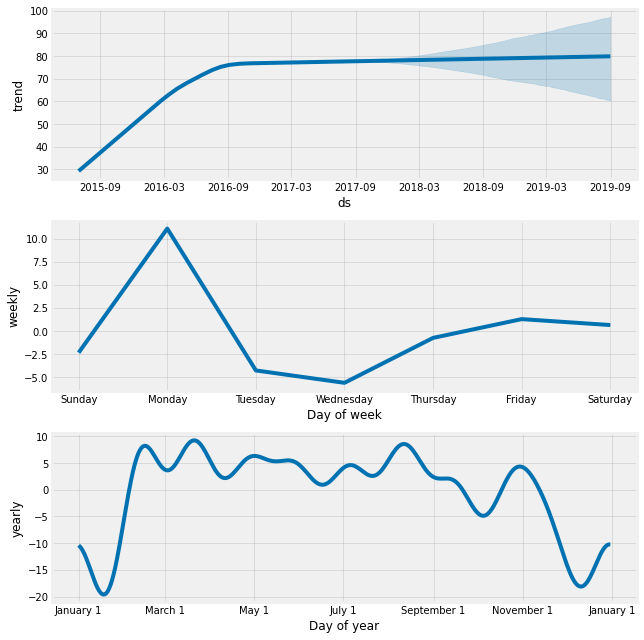

In [55]:
# Transient Customer Arrival

customers = city_df['customer_type'].unique()

customer_df = df[df['customer_type'] == 'Transient']
customer_df = customer_df[customer_df['reservation_status']=='Check-Out'].groupby('arrival_date').count()['hotel']
customer_df = customer_df.reset_index()
customer_df.columns = ['ds','y']

m = Prophet()
m.fit(customer_df)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
print('Transient')
pd.plotting.register_matplotlib_converters()
m.plot_components(forecast);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Contract


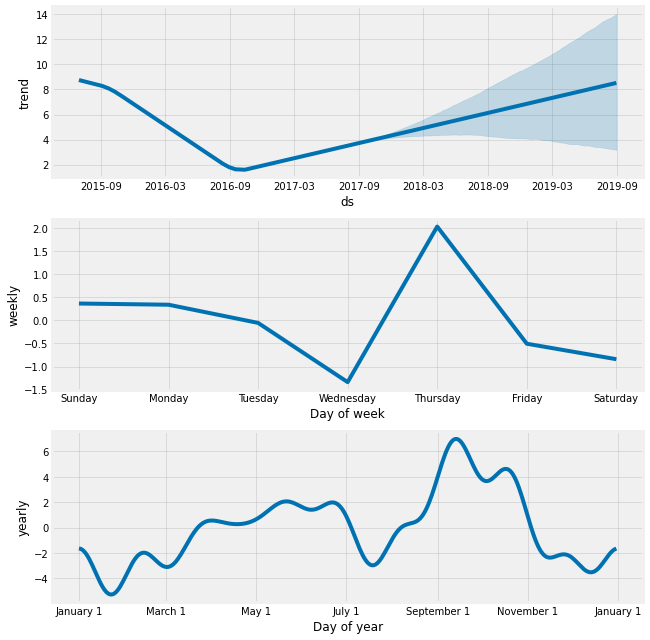

In [56]:
# Contract Customer Arrival

customer_df = df[df['customer_type'] == 'Contract']
customer_df = customer_df[customer_df['reservation_status']=='Check-Out'].groupby('arrival_date').count()['hotel']
customer_df = customer_df.reset_index()
customer_df.columns = ['ds','y']

m = Prophet()
m.fit(customer_df)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
print('Contract')
pd.plotting.register_matplotlib_converters()
m.plot_components(forecast);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Transient-Party


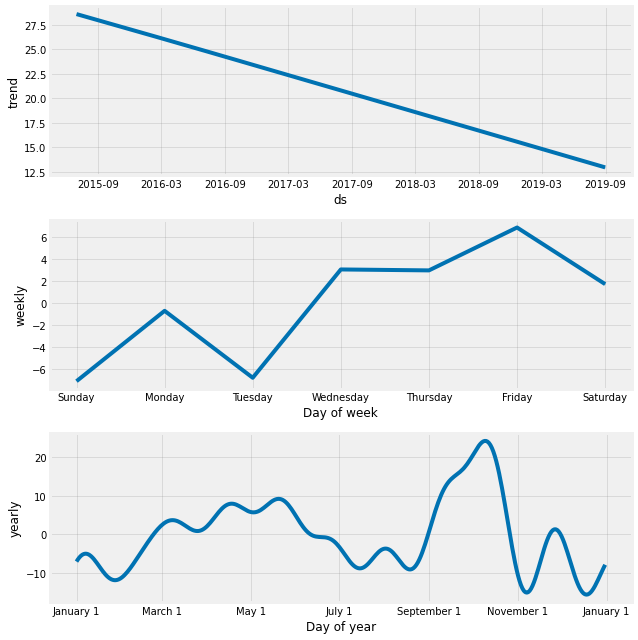

In [57]:
# Transient-Party Customer Arrival

customer_df = df[df['customer_type'] == 'Transient-Party']
customer_df = customer_df[customer_df['reservation_status']=='Check-Out'].groupby('arrival_date').count()['hotel']
customer_df = customer_df.reset_index()
customer_df.columns = ['ds','y']

m = Prophet()
m.fit(customer_df)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
print('Transient-Party')
pd.plotting.register_matplotlib_converters()
m.plot_components(forecast);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Group


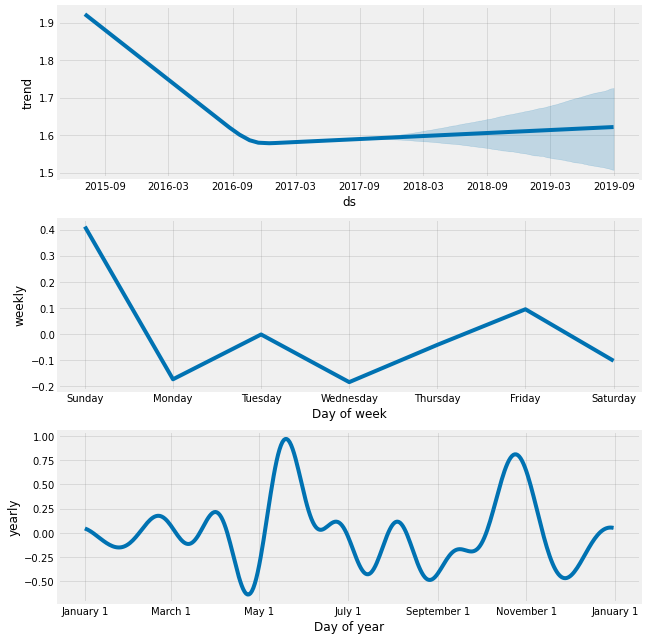

In [58]:
# Group Customer Arrival

customer_df = df[df['customer_type'] == 'Group']
customer_df = customer_df[customer_df['reservation_status']=='Check-Out'].groupby('arrival_date').count()['hotel']
customer_df = customer_df.reset_index()
customer_df.columns = ['ds','y']

m = Prophet()
m.fit(customer_df)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
print('Group')
pd.plotting.register_matplotlib_converters()
m.plot_components(forecast);

In [59]:
city_df['last_stay_date'] = city_df['arrival_date'] + city_df['LOS'].apply(lambda x: pd.DateOffset(x-1))

df_lite = city_df[['arrival_date','last_stay_date']]
df_lite = df_lite.reset_index()
df2 = pd.melt(df_lite, id_vars='index', value_name = 'stay_date')
df2['stay_date'] = pd.to_datetime(df2['stay_date'])
df2.set_index('stay_date', inplace=True)
df2.drop('variable', axis=1, inplace=True)

In [60]:
df3 = df2.groupby('index').resample('D').ffill().reset_index(level=0, drop=True).reset_index()

In [61]:
city_df_lite = pd.merge(df_lite,df3)

In [62]:
city_df_staydates = pd.merge(city_df_lite,city_df)

In [63]:
# plotting city full occupancy (checked out)
# city_df_occ = city_df_lite[['stay_date','index']]
# city_df_occ.columns = ['ds','y']

# m = Prophet()
# m.fit(city_df_occ)
# future = m.make_future_dataframe(periods=730)
# forecast = m.predict(future)

In [64]:
# Resort Dataframe add Pattern Dates


# resort_df['last_stay_date'] = resort_df['arrival_date'] + resort_df['LOS'].apply(lambda x: pd.DateOffset(x-1))

# df_lite = resort_df[['arrival_date','last_stay_date']]
# df_lite = df_lite.reset_index()
# df2 = pd.melt(df_lite, id_vars='index', value_name = 'stay_date')
# df2['stay_date'] = pd.to_datetime(df2['stay_date'])
# df2.set_index('stay_date', inplace=True)
# df2.drop('variable', axis=1, inplace=True)

In [65]:
# df3 = df2.groupby('index').resample('D').ffill().reset_index(level=0, drop=True).reset_index()